# MBD-O2 Spark Final Assignment


# Group - D

# Machine Learning with Spark and AbadIA

![cover](images/cover.png)

Created in Spain and based in the movie:

![rose](images/rose.png)

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from scipy.spatial import distance

In [147]:
from IPython.display import Image
from IPython.core.display import HTML 


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext



We read the json files from the github repo. 

**PySpark**

In [3]:
df = spark.read.json('./SparkCourse2019/datasets/AbadIA2/actions/*.json')

We then count the number of rows we have

In [5]:
df.count()

88565

We know it's a JSON file so there will be a structure in it. We print the Schema to see it and be able to pull information out 

In [6]:
df.printSchema()

root
 |-- action: struct (nullable = true)
 |    |-- action: long (nullable = true)
 |    |-- nextstate: struct (nullable = true)
 |    |    |-- Objetos: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- Personajes: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- altura: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- nombre: string (nullable = true)
 |    |    |    |    |-- objetos: long (nullable = true)
 |    |    |    |    |-- orientacion: long (nullable = true)
 |    |    |    |    |-- posX: long (nullable = true)
 |    |    |    |    |-- posY: long (nullable = true)
 |    |    |-- Rejilla: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |-- bonus: long (nullable = true)
 |    |    |-- dia: long (nullable = true)
 |    |  

![gameplay](images/game.png)

We then decide which attributes we want to pull from this structure.

For the Map Data, we have an element - element  in the JSON document. That normally means a 2D array hidden as an array inside an array.  
We can use this Rejilla's made as an array to plot the map of the rooms in matplotlib 

In [7]:
data=df.select("action.nextstate.Personajes.nombre",
               "action.nextstate.Personajes.posX",
               "action.nextstate.Personajes.posY",
               "action.nextstate.dia",
               "action.nextstate.momentoDia",
               "action.nextstate.reward",
               "action.nextstate.Personajes.altura",
               "action.nextstate.Personajes.orientacion",
               "action.nextstate.numPantalla",
               "action.nextstate.obsequium",
              )

We get that into a Pandas DataFrame so we can plot and see it 

![map](images/map.png)

**Python**

We use python to plot and see the different rooms

In [8]:
map_data = df.select(["action.nextstate.Rejilla", "action.nextstate.numPantalla"]).toPandas()

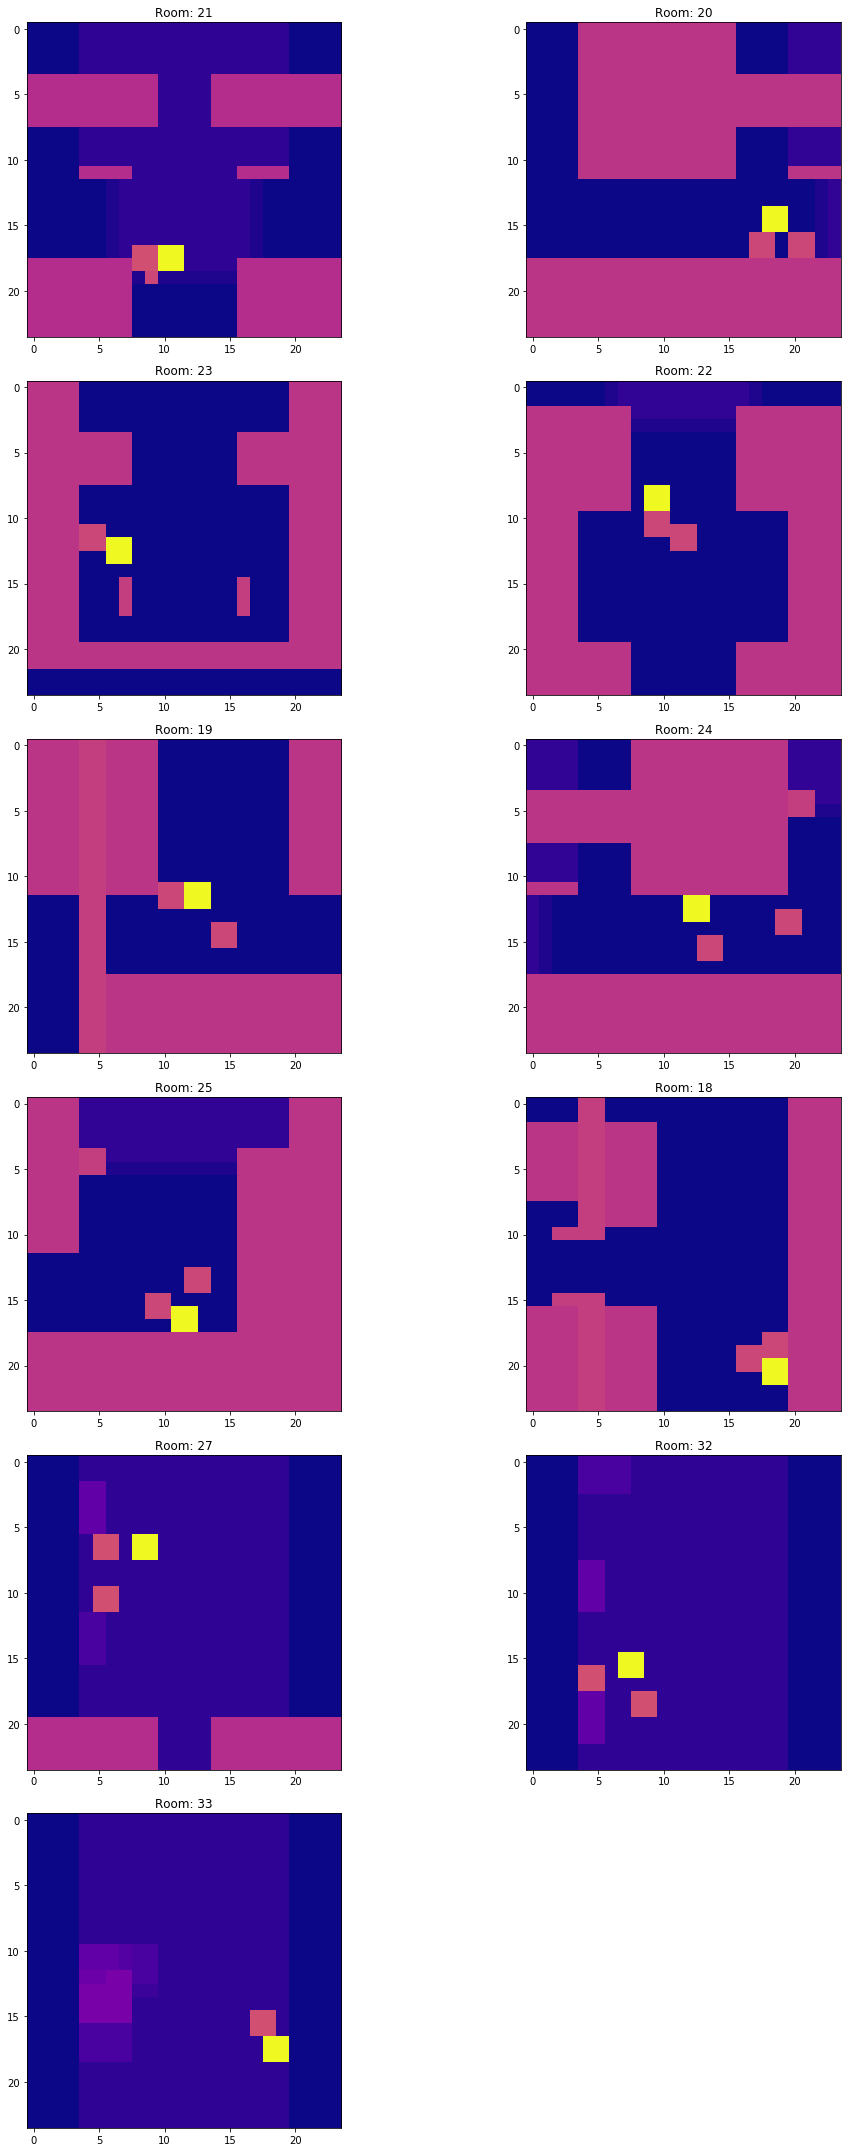

In [9]:
plt.subplots(figsize=(15,30))
rooms = map_data['numPantalla'].unique()

for i, room in enumerate(rooms):
    plt.subplot(6,2,i+1)
    plt.imshow(np.array(map_data.loc[map_data['numPantalla'] == room, 'Rejilla'].sample(1).values[0]),
               cmap='plasma')
    plt.title("Room: " + str(room))
plt.tight_layout()

![map](images/section.png)

**PySpark**

In [10]:
data.describe().show()

+-------+-----+----------+--------------------+------------------+------------------+
|summary|  dia|momentoDia|              reward|       numPantalla|         obsequium|
+-------+-----+----------+--------------------+------------------+------------------+
|  count|88565|     88565|               88565|             88565|             88565|
|   mean|  1.0|       4.0|-0.00561747981708...|  21.8543329757805|15.762603737368035|
| stddev|  0.0|       0.0| 0.07265083664791303|1.3708485527179033|10.150507846117947|
|    min|    1|         4|                -1.0|                18|                 0|
|    max|    1|         4|               0.005|                33|                31|
+-------+-----+----------+--------------------+------------------+------------------+



We can see that dia and momentoDia are constant. So we can take those off

We also check the names as those are the players present in a room in each state

In [13]:
data.groupBy('nombre').count().show(4, False)

+---------------------------------+-----+
|nombre                           |count|
+---------------------------------+-----+
|[Guillermo, Adso]                |12609|
|[Guillermo, Adso, Abad]          |67071|
|[Guillermo, Adso, Severino]      |52   |
|[Guillermo, Adso, Abad, Severino]|8830 |
+---------------------------------+-----+
only showing top 4 rows



This tells us that Guillermo and Adso are both present in every frame in the game. The other 2 players appear only sometimes. We can then calculate the distance between these 2 players and see if there is a correlation with the rewards

We could also try to create a flag if Abad is present , but this complicates the scope fo this notebook and we prefer to keep things simple

In [28]:
data=df.selectExpr("action.nextstate.reward",
                   "action.nextstate.numPantalla",
                   "action.nextstate.Personajes.altura[0] as altura_G",
                   "action.nextstate.Personajes.altura[2] as altura_A",
                   "action.nextstate.Personajes.orientacion",
                   "action.nextstate.obsequium",
                   "action.nextstate.Personajes.posX[0] as posx_G",
                   "action.nextstate.Personajes.posY[0] as posy_G",
                   "action.nextstate.Personajes.posX[1] as posx_A",
                   "action.nextstate.Personajes.posY[1] as posy_A",
                   "action.action",
                   "action.nextstate.Personajes.nombre"
                  )

We calculate the Euclidean Distance between Guillermo and Adso in every frame to see if that has a correlation with reward

In [29]:
data = data.withColumn(
    'dist',
    F.sqrt((F.col('posy_G') - F.col('posy_A'))**2 \
           + (F.col('posx_G') - F.col('posx_A'))**2))

We got the 2D euclidean distance between Guillermo and Abad using their X, Y. 
We also found out that orientacion is not really relevant without some very complicated context, the name array we don't need anymore either so we drop them. We also won't use Adso's position as it complicates matters and we already have the distance as a feature. So we drop it as well. Same with the altura for both characters

In [30]:
data = data.drop('orientacion', 'posx_A', 'posy_A', 'nombre', 'altura_G', 'altura_A')

In [31]:
data.printSchema()

root
 |-- reward: double (nullable = true)
 |-- numPantalla: long (nullable = true)
 |-- obsequium: long (nullable = true)
 |-- posx_G: long (nullable = true)
 |-- posy_G: long (nullable = true)
 |-- action: long (nullable = true)
 |-- dist: double (nullable = true)



Checking that there are no null values 

In [32]:
data.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in data.columns]).show()

+------+-----------+---------+------+------+------+----+
|reward|numPantalla|obsequium|posx_G|posy_G|action|dist|
+------+-----------+---------+------+------+------+----+
|     0|          0|        0|     0|     0|     0|   0|
+------+-----------+---------+------+------+------+----+



In [33]:
data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in data.columns]).show()

+------+-----------+---------+------+------+------+----+
|reward|numPantalla|obsequium|posx_G|posy_G|action|dist|
+------+-----------+---------+------+------+------+----+
|     0|          0|        0|     0|     0|     0|   0|
+------+-----------+---------+------+------+------+----+



So we have no null values and we can start Visualizing different parameters

## EDA

In [34]:
data.printSchema()

root
 |-- reward: double (nullable = true)
 |-- numPantalla: long (nullable = true)
 |-- obsequium: long (nullable = true)
 |-- posx_G: long (nullable = true)
 |-- posy_G: long (nullable = true)
 |-- action: long (nullable = true)
 |-- dist: double (nullable = true)



We can plot the average reward and obsequium on all positions so we can see how the areas compare to each other.  
For this we will use matplotlib and as we're dealing with 88k rows and 7 features. We can easily convert it back to python for this

**Python**

In [35]:
df = data.toPandas()

In [36]:
df.head()

,reward,numPantalla,obsequium,posx_G,posy_G,action,dist
0,-0.0001,21,31,137,143,1,2.000000
1,-0.0001,21,31,136,143,6,3.000000
2,-0.0060,21,29,137,142,1,2.000000
3,-0.0001,21,29,136,141,7,3.162278
4,-0.0001,21,29,136,141,2,3.162278


First we see the distribution fo rewards and wether it should be treated as a continuous (regression) or categorical (classification) parameter

In [37]:
df['reward'].nunique()

10

Text(0.5,1,'Count of Rewards')

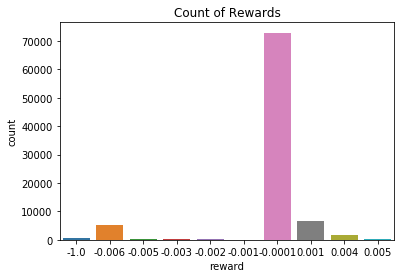

In [38]:
sns.countplot(data=df, x='reward')
plt.title("Count of Rewards")

We can see that this is heavily unbalanced towards the -0.0001 reward (basically when nothing happens. 

We can also see if any specific room is more dangerous than others

Text(0.5,1,'Dangerous rooms by average')

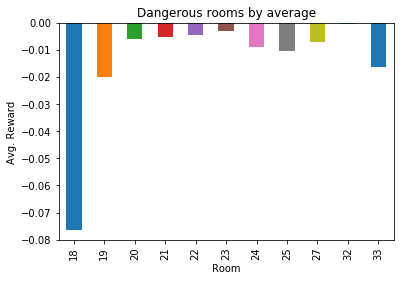

In [39]:
df.groupby('numPantalla').mean()['reward'].plot.bar()
plt.xlabel("Room")
plt.ylabel("Avg. Reward")
plt.title("Dangerous rooms by average")

We also want to see if there is a correlation between Obsequium (whatever the hell that is) and the reward

Text(0.5,1,'Reward by Ammount of Obsequium')

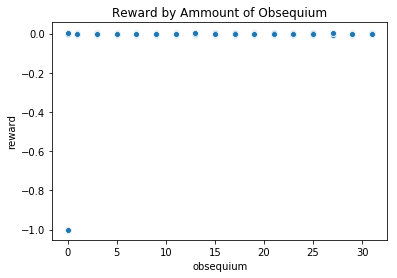

In [40]:
sns.scatterplot(data=df, x='obsequium', y='reward')
plt.title("Reward by Ammount of Obsequium")

Ok.. it seems like when you hit 0 you die as the worst reward is there. 

Then we check actions by reward and count of actions to see if there is any information there

E:\Anaconda3\envs\basicdata\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of Actions when Obsequium = 0')

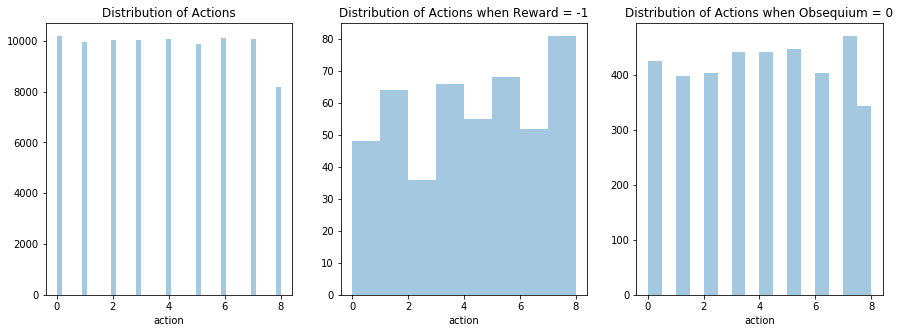

In [41]:
plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
sns.distplot(df['action'], kde=False)
plt.title('Distribution of Actions')
plt.subplot(1,3,2)
sns.distplot(df.loc[df['reward'] == -1, 'action'], kde=False)
plt.title("Distribution of Actions when Reward = -1")
plt.subplot(1,3,3)
sns.distplot(df.loc[df['obsequium'] == 0, 'action'], kde=False)
plt.title("Distribution of Actions when Obsequium = 0")

We plot the distribution of distance to see how it behaves in univariate

E:\Anaconda3\envs\basicdata\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


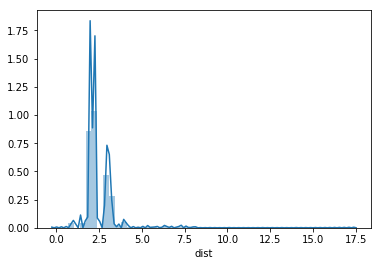

In [42]:
sns.distplot(df['dist'])

We can see that although there are some large values, in the vast majority of the cases, Guillermo and Adso are close to each other

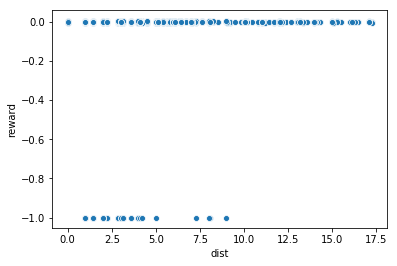

In [43]:
sns.scatterplot(data=df, x='dist', y='reward')

In [51]:
print('Steps with -1 reward: ', len(df[df['reward'] == -1]))
print('Steps with 0 Obsequium: ', len(df[df['obsequium'] == 0]))

Steps with -1 reward:  470
Steps with 0 Obsequium:  3776


Seems like we have more steps with 0 obsequium but not with -1 reward. We originally thought that those would be the same as it meanth deth and therefore the lowest reward possible. We will check the distribution of each other with the min of each

E:\Anaconda3\envs\basicdata\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
E:\Anaconda3\envs\basicdata\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
E:\Anaconda3\envs\basicdata\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
E:\Anaconda3\envs\basicdata\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


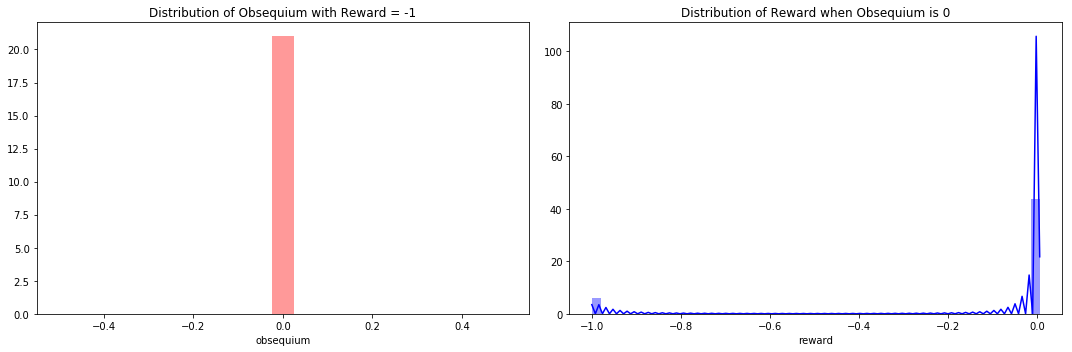

In [53]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df.loc[df['reward'] == -1, 'obsequium'], color='red')
plt.title("Distribution of Obsequium with Reward = -1")
plt.subplot(1,2,2)
sns.distplot(df.loc[df['obsequium'] == 0, 'reward'], color='blue')
plt.title("Distribution of Reward when Obsequium is 0")
plt.tight_layout()

So it seems every time we had reward = -1 it meant that the obsequium was 0. But not every time obsequium was 0 it meant that we had -1 reward. In fact most of the times we had close to 0 reward. This is something we could investigate in the future

Finally we can plot against the position in X and Y which should show us an overview of the game world

In [54]:
df.head()

,reward,numPantalla,obsequium,posx_G,posy_G,action,dist
0,-0.0001,21,31,137,143,1,2.000000
1,-0.0001,21,31,136,143,6,3.000000
2,-0.0060,21,29,137,142,1,2.000000
3,-0.0001,21,29,136,141,7,3.162278
4,-0.0001,21,29,136,141,2,3.162278


![section](images/section.png)

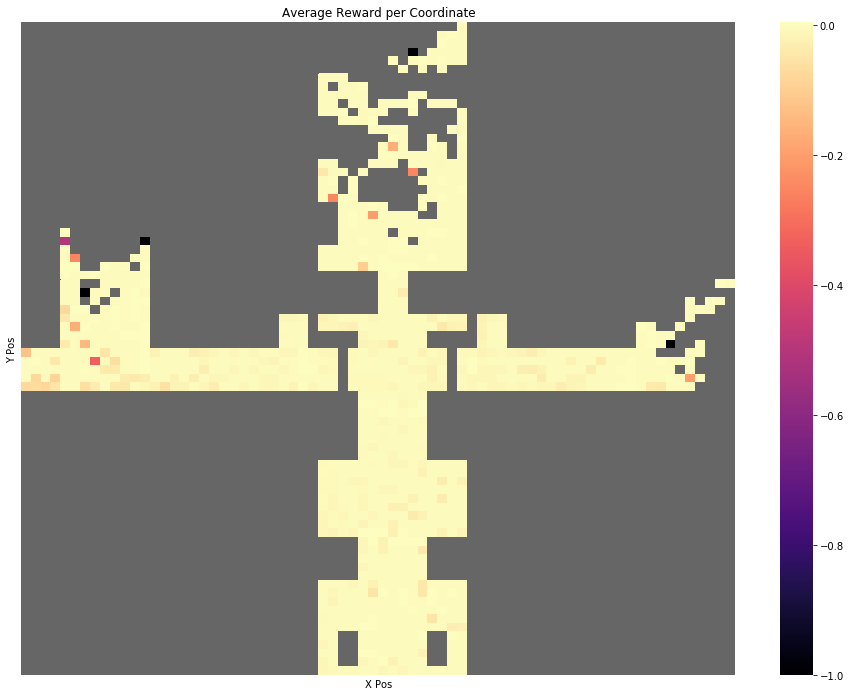

In [121]:
plt.subplots(figsize=(16,12))
reward_map_p = df.groupby(by=['posx_G', 'posy_G']).mean().pivot_table('reward', 'posy_G', 'posx_G')
heatmap = plt.cm.get_cmap("magma")
heatmap.set_bad(color="#666666")
sns.heatmap(reward_map_p, cmap=heatmap, xticklabels=False, yticklabels=False)
plt.title("Average Reward per Coordinate")
plt.xlabel('X Pos')
plt.ylabel('Y Pos');


This graph shows us that the reward is mostly close to 0 ion the entrance and as it goes on exploring the average reward gets worse. There are some spots in the farthest reaches that have very negative rewards. They look like "sure death spots"

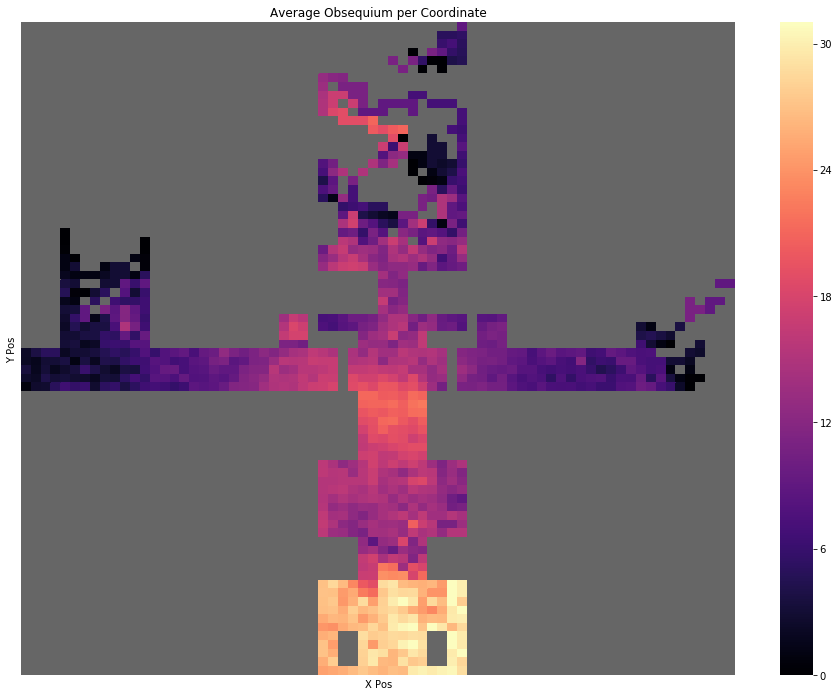

In [122]:
plt.subplots(figsize=(16,12))
reward_map_p = df.groupby(by=['posx_G', 'posy_G']).mean().pivot_table('obsequium', 'posy_G', 'posx_G')
heatmap = plt.cm.get_cmap("magma")
heatmap.set_bad(color="#666666")
sns.heatmap(reward_map_p, cmap=heatmap, yticklabels=False, xticklabels=False)
plt.title("Average Obsequium per Coordinate")
plt.xlabel('X Pos')
plt.ylabel('Y Pos');


In this map we can see the average obsequium as it goes down. We remember that obsequium 0 is related to dying.  
We can see that the entrance is a high obsequium range as it's a brand new game. But as soon as it starts exploring it starts going down and finally hits 0 close to the areas furthest explored

We also want to check of there are any "safe spots" were we never die. For this we will check the minimum reward for every coordinate

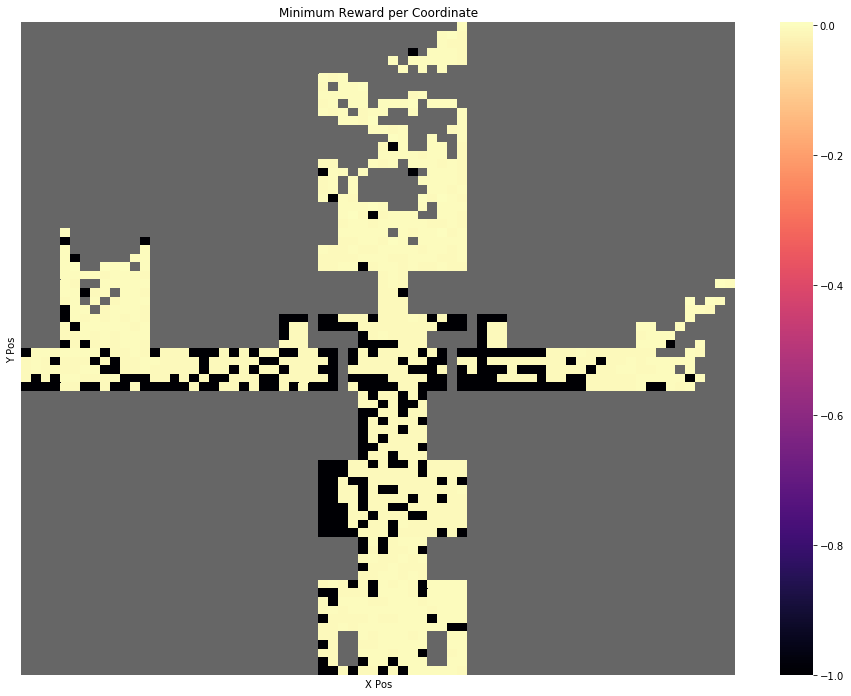

In [123]:
plt.subplots(figsize=(16,12))
reward_map_p = df.groupby(by=['posx_G', 'posy_G']).min().pivot_table('reward', 'posy_G', 'posx_G')
heatmap = plt.cm.get_cmap("magma")
heatmap.set_bad(color="#666666")
sns.heatmap(reward_map_p, cmap=heatmap, xticklabels=False, yticklabels=False)
plt.title("Minimum Reward per Coordinate")
plt.xlabel('X Pos')
plt.ylabel('Y Pos');


![death](images/death.jpg)

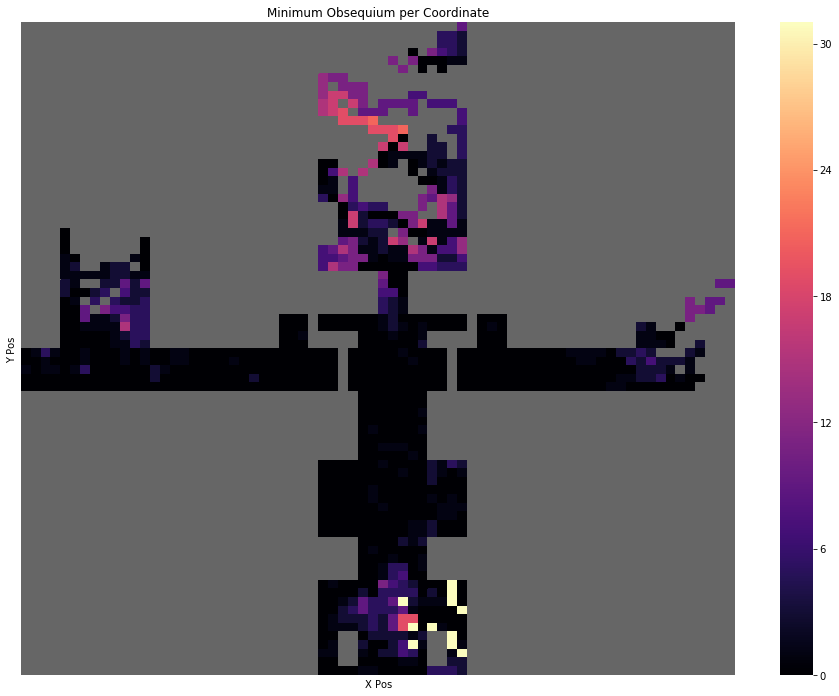

In [233]:
plt.subplots(figsize=(16,12))
reward_map_p = df.groupby(by=['posx_G', 'posy_G']).min().pivot_table('obsequium', 'posy_G', 'posx_G')
heatmap = plt.cm.get_cmap("magma")
heatmap.set_bad(color="#666666")
sns.heatmap(reward_map_p, cmap=heatmap, xticklabels=False, yticklabels=False)
plt.title("Minimum Obsequium per Coordinate")
plt.xlabel('X Pos')
plt.ylabel('Y Pos');


From this graph we can see that we can die pretty much everywhere. Althought most deaths seem to be sticking to walls. It could be the random agent taking actions like move against a wall as it being the least worst action. This could mean that we need to tweak the reward function a bit to incetivize the agent to take riskier moves. But the main takeaway is that we can die anywhere

## Modelling

### LinearRegression 

**PySpark**

In [125]:
data.printSchema()

root
 |-- reward: double (nullable = true)
 |-- numPantalla: long (nullable = true)
 |-- obsequium: long (nullable = true)
 |-- posx_G: long (nullable = true)
 |-- posy_G: long (nullable = true)
 |-- action: long (nullable = true)
 |-- dist: double (nullable = true)



In [129]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression

In [234]:
encoder_num = OneHotEncoder(inputCol='numPantalla', outputCol='numPantallaVec')
encoder_action = OneHotEncoder(inputCol='action', outputCol='actionVec')
assembler = VectorAssembler(inputCols=[
    'numPantallaVec',
    'obsequium',
    'posx_G',
    'posy_G',
    'actionVec',
    'dist',
],
    outputCol='features'
)
lr_model_spark = LinearRegression(featuresCol='features', labelCol='reward')

In [235]:
pipe = Pipeline(stages=[encoder_num, encoder_action,
                        assembler])

In [236]:
final_data = pipe.fit(data).transform(data)

In [238]:
train_data, test_data = final_data.randomSplit([0.6, 0.4], 8008)

![Model Training](images/modeltrain.jpg)

In [239]:
fit_model = lr_model_spark.fit(train_data)

In [240]:
results = fit_model.evaluate(test_data)

In [241]:
print("R2 of our Model: {}".format(results.r2))
print("RMSE of our Model: {}".format(results.rootMeanSquaredError))

R2 of our Model: 0.013589132528264547
RMSE of our Model: 0.07131702371754653


Our model SUCKS SOOOO MUCH !

![sucks](images/ugh.jpg)

We then tried to remove the categorization of numPantallas and actions and see if it makes the model any better. But first we will check correlation between the variables/

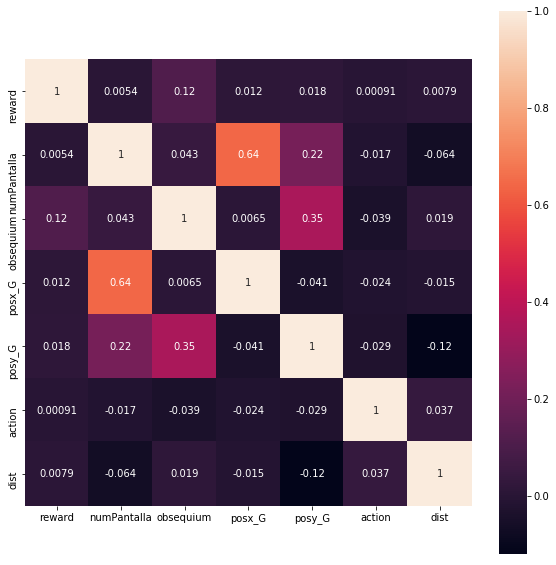

In [151]:
plt.subplots(figsize=(10,10))
sns.heatmap(data.toPandas().corr(), square=True, annot=True)

Seems like action is completely independent from the reward, so is the distance, the numPantalla

### Otra Oportunidad!

In [154]:
assembler = VectorAssembler(inputCols=[
    'obsequium',
    'posx_G',
    'posy_G',
],
    outputCol='features')

In [156]:
final_data = assembler.transform(data)

In [157]:
train_data, test_data = final_data.randomSplit([0.6, 0.4], 8008)

In [158]:
lr_model_spark2 = LinearRegression(labelCol='reward')

In [159]:
fit_model = lr_model_spark2.fit(train_data)

In [160]:
results = fit_model.evaluate(test_data)

In [161]:
print("R2 of our Model: {}".format(results.r2))
print("RMSE of our Model: {}".format(results.rootMeanSquaredError))

R2 of our Model: 0.013219187206172323
RMSE of our Model: 0.07133039589689089


**Nice!  made it even worse!!!**

![rain](images/rain.gif)

We add the uncorrelated features again but without categorizing them

### Otra Oportunidad!

In [163]:
assembler = VectorAssembler(inputCols=[
    'obsequium',
    'posx_G',
    'posy_G',
    'numPantalla',
    'action',
    'dist'
],
    outputCol='features')

In [164]:
final_data = assembler.transform(data)
train_data, test_data = final_data.randomSplit([0.6, 0.4], 8008)

In [165]:
lr_model_spark3 = LinearRegression(labelCol='reward')
fit_model = lr_model_spark2.fit(train_data)
results = fit_model.evaluate(test_data)

In [166]:
print("R2 of our Model: {}".format(results.r2))
print("RMSE of our Model: {}".format(results.rootMeanSquaredError))

R2 of our Model: 0.013255711369180245
RMSE of our Model: 0.07132907579262789


### Otra Oportuinidad!

In [169]:
assembler = VectorAssembler(inputCols=[
    'posx_G',
    'posy_G',
],
    outputCol='features')

In [170]:
final_data = assembler.transform(data)
train_data, test_data = final_data.randomSplit([0.6, 0.4], 8008)

In [171]:
lr_model_spark3 = LinearRegression(labelCol='reward')
fit_model = lr_model_spark2.fit(train_data)
results = fit_model.evaluate(test_data)

In [172]:
print("R2 of our Model: {}".format(results.r2))
print("RMSE of our Model: {}".format(results.rootMeanSquaredError))

R2 of our Model: 0.000370927692750489
RMSE of our Model: 0.07179326844630023


![sad](images/worse.jpg)

As a last attempt. We see that the distinct values for reward are only 10, so this could be made into a classification problem

In [173]:
data.printSchema()

root
 |-- reward: double (nullable = true)
 |-- numPantalla: long (nullable = true)
 |-- obsequium: long (nullable = true)
 |-- posx_G: long (nullable = true)
 |-- posy_G: long (nullable = true)
 |-- action: long (nullable = true)
 |-- dist: double (nullable = true)



In [184]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [204]:
indexer = StringIndexer(inputCol='reward', outputCol='rewardInd')
encoder_num = OneHotEncoder(inputCol='numPantalla', outputCol="numPantallaVec")
encoder_action = OneHotEncoder(inputCol='action', outputCol='actionVec')
assembler = VectorAssembler(inputCols=[
                            "numPantallaVec",
                            "obsequium",
                            "posx_G",
                            "posy_G",
                            "actionVec"],
                            outputCol='features')

In [208]:
final_data = indexer.fit(data).transform(data)
final_data = encoder_num.transform(final_data)
final_data = encoder_action.transform(final_data)
final_data = assembler.transform(final_data)
train_data, test_data = final_data.randomSplit([0.6, 0.4], 8008)

In [209]:
evaluator = MulticlassClassificationEvaluator(labelCol='rewardInd')

In [210]:
log_reg_model = LogisticRegression(featuresCol='features', labelCol='rewardInd')
fit_model = log_reg_model.fit(train_data)
results = fit_model.transform(test_data)

In [211]:
evaluator.evaluate(results)

0.8237246844382207

![balance2](images/unbalanced2.jpg)

In [212]:
results.groupBy('reward').count().show()

+-------+-----+
| reward|count|
+-------+-----+
|  0.005|  109|
|   -1.0|  184|
| -0.003|  174|
| -0.005|  167|
| -0.002|  120|
|-1.0E-4|29164|
| -0.006| 2111|
|  0.001| 2723|
|  0.004|  741|
| -0.001|    4|
+-------+-----+



In [213]:
results.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|31453|
|       1.0| 4016|
|       3.0|   23|
|       9.0|    5|
+----------+-----+



![fine](images/fine.jpg)

### Random Forest

In [216]:
indexer = StringIndexer(inputCol='reward', outputCol='rewardInd')
encoder_num = OneHotEncoder(inputCol='numPantalla', outputCol="numPantallaVec")
encoder_action = OneHotEncoder(inputCol='action', outputCol='actionVec')
assembler = VectorAssembler(inputCols=[
                            "numPantallaVec",
                            "obsequium",
                            "posx_G",
                            "posy_G",
                            "actionVec"],
                            outputCol='features')

In [217]:
final_data = indexer.fit(data).transform(data)
final_data = encoder_num.transform(final_data)
final_data = encoder_action.transform(final_data)
final_data = assembler.transform(final_data)
train_data, test_data = final_data.randomSplit([0.6, 0.4], 8008)

In [218]:
evaluator = MulticlassClassificationEvaluator(labelCol='rewardInd')

In [219]:
rf_model = RandomForestClassifier(labelCol="rewardInd", numTrees=100)
fit_model = rf_model.fit(train_data)
results = fit_model.transform(test_data)

In [220]:
evaluator.evaluate(results)

0.7430500119314015

This could be a bit better. But it's most likely still because of the unbalanced dataset

In [224]:
test_cm = results.select(['rewardInd', 'prediction']).toPandas()

In [226]:
from sklearn.metrics import classification_report, confusion_matrix

In [228]:
print(confusion_matrix(test_cm['rewardInd'], test_cm['prediction']))

[[29155     9     0     0     0     0     0     0     0     0]
 [ 2694    29     0     0     0     0     0     0     0     0]
 [ 2111     0     0     0     0     0     0     0     0     0]
 [  741     0     0     0     0     0     0     0     0     0]
 [  180     4     0     0     0     0     0     0     0     0]
 [  173     1     0     0     0     0     0     0     0     0]
 [  167     0     0     0     0     0     0     0     0     0]
 [  117     3     0     0     0     0     0     0     0     0]
 [  107     2     0     0     0     0     0     0     0     0]
 [    4     0     0     0     0     0     0     0     0     0]]


Code to print CM without going to pandas. 

In [230]:
# from pyspark.mllib.evaluation import MulticlassMetrics
# # Create (prediction, label) pairs
# predictionAndLabel = results.select("prediction", "rewardInd").rdd

# # Generate confusion matrix
# metrics = MulticlassMetrics(predictionAndLabel)
# print(metrics.confusionMatrix())


## Visualizing predictions

In [242]:
preds = fit_model.transform(test_data)

In [244]:
map_data_2 = preds.select(['prediction', 'posx_G', 'posy_G']).toPandas()

**Python**

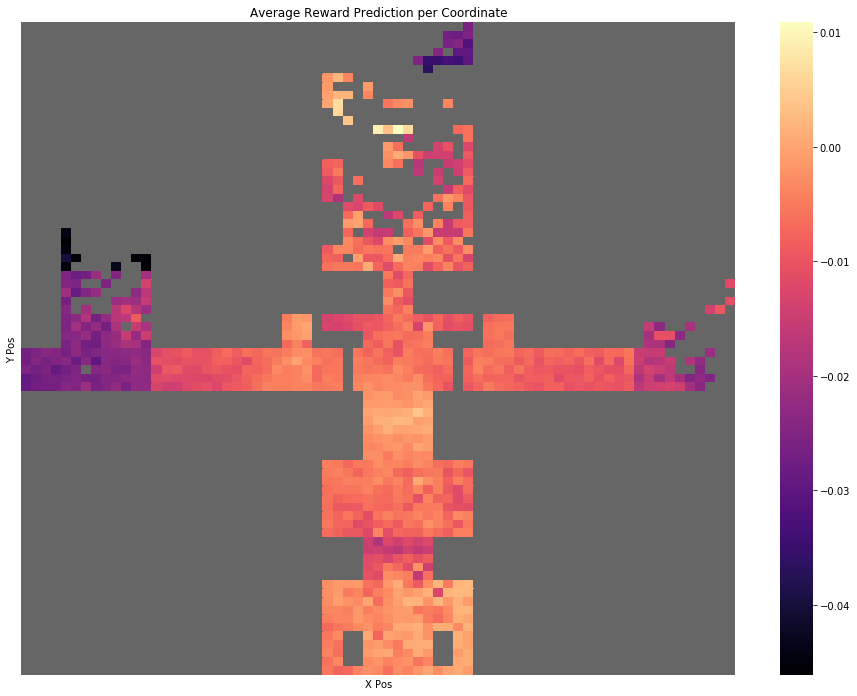

In [246]:
plt.subplots(figsize=(16,12))
reward_map_p = map_data_2.pivot_table('prediction', 'posy_G', 'posx_G')
heatmap = plt.cm.get_cmap("magma")
heatmap.set_bad(color="#666666")
sns.heatmap(reward_map_p, cmap=heatmap, xticklabels=False, yticklabels=False)
plt.title("Average Reward Prediction per Coordinate")
plt.xlabel('X Pos')
plt.ylabel('Y Pos');


![ml](images/ml.jpg)

# Bonus

We want to try and find a gradient of reward prediction per room. Training a model for each one and only using the positions

In [248]:
data.printSchema()

root
 |-- reward: double (nullable = true)
 |-- numPantalla: long (nullable = true)
 |-- obsequium: long (nullable = true)
 |-- posx_G: long (nullable = true)
 |-- posy_G: long (nullable = true)
 |-- action: long (nullable = true)
 |-- dist: double (nullable = true)



In [249]:
bonus_data = data.select(['reward', 'posx_G', 'posy_G', 'numPantalla']).toPandas()

In [250]:
bonus_data.head(1)

,reward,posx_G,posy_G,numPantalla
0,-0.0001,137,143,21


In [251]:
from sklearn.linear_model import LinearRegression

In [281]:
rooms = bonus_data['numPantalla'].unique()
total_predictions = pd.DataFrame()

for room in rooms:
    filter_data = bonus_data.loc[bonus_data['numPantalla'] == room, :]
    X = filter_data.drop(['reward', 'numPantalla'], axis=1)
    y = filter_data['reward']
    model = LinearRegression()
    model.fit(X, y)
    X.drop_duplicates(inplace=True)
    preds = model.predict(X)  # Because cool people overfit
    X['prediction'] = preds
    X['room'] = room
    total_predictions = pd.concat([total_predictions, X])
    

In [282]:
len(total_predictions)  # We only have distinct 1142 coordinates

1142

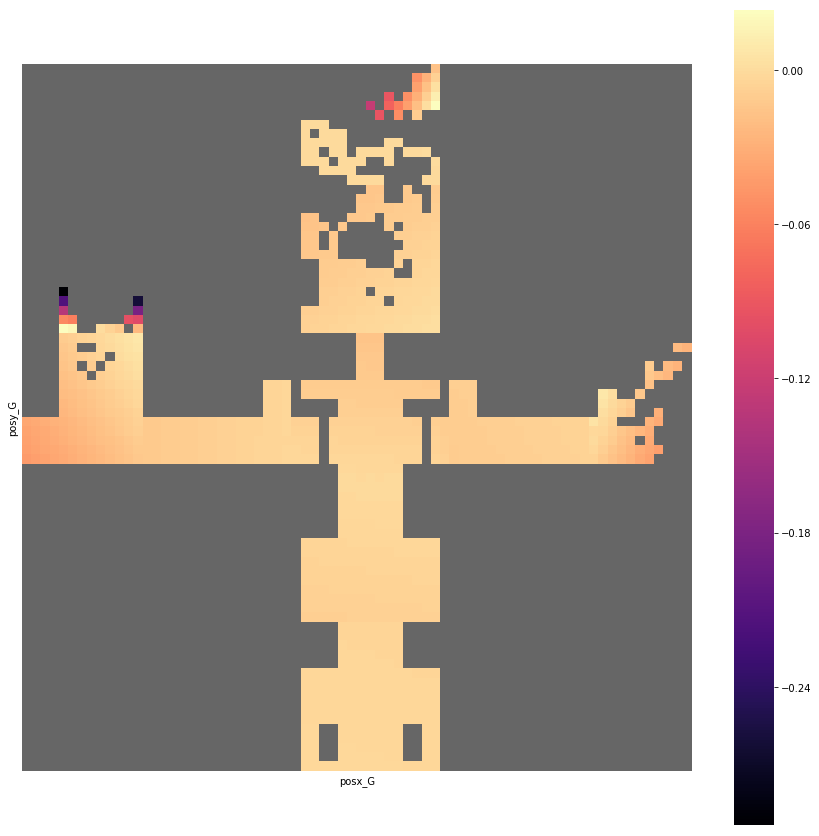

In [286]:
plt.subplots(figsize=(15,15))
heatmap = plt.cm.get_cmap("magma")
heatmap.set_bad(color="#666666")
sns.heatmap(total_predictions.pivot_table('prediction', 'posy_G', 'posx_G'),
            xticklabels=False,
            yticklabels=False,
            square=True,
            cmap=heatmap)

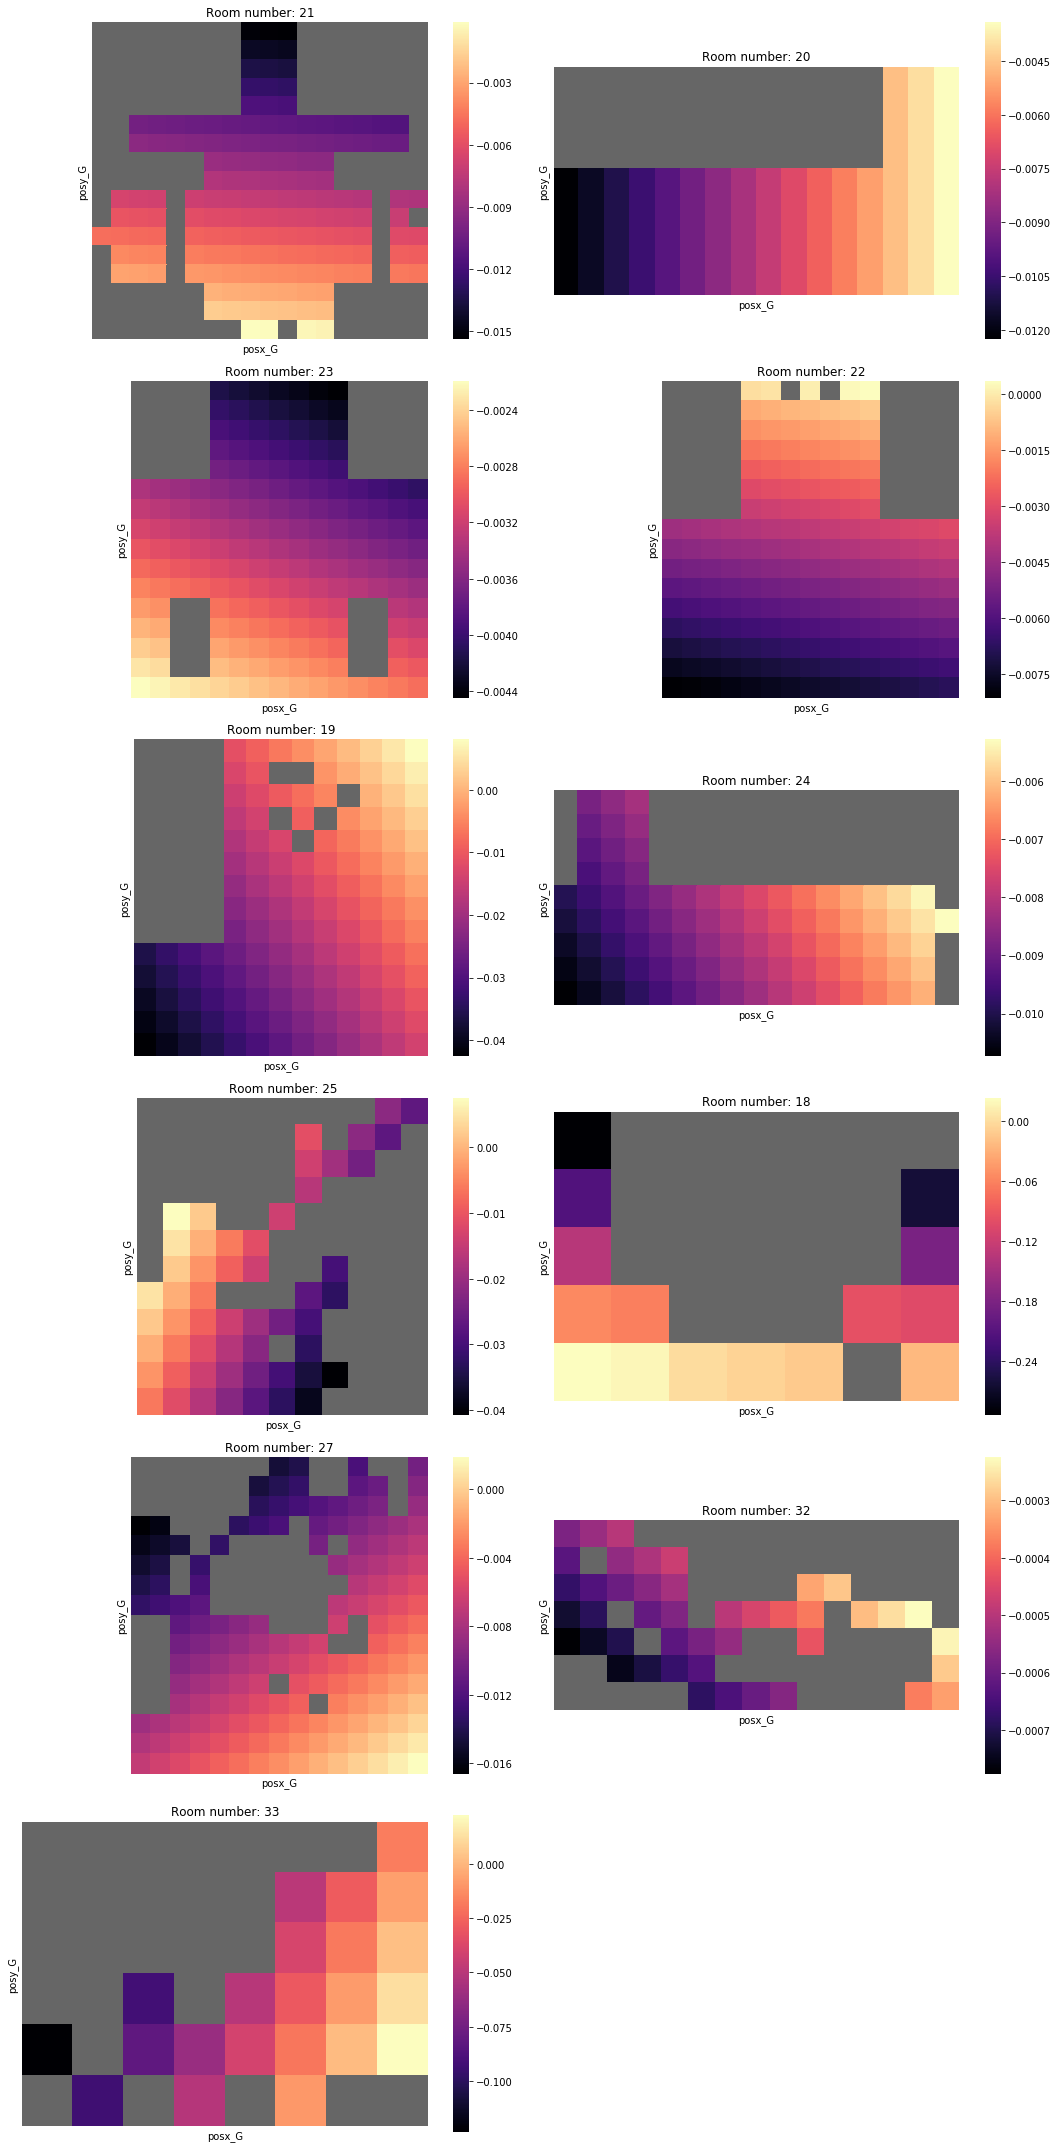

In [290]:
plt.subplots(figsize=(15,30))
for i, room in enumerate(rooms):
    filter_data = total_predictions.loc[total_predictions['room'] == room, ['posx_G', 'posy_G', 'prediction']]
    map_data = filter_data.pivot_table('prediction', 'posy_G', 'posx_G')
    plt.subplot(6,2,i+1)
    sns.heatmap(map_data, yticklabels=False, xticklabels=False, square=True, cmap=heatmap)
    plt.title("Room number: " + str(room))
plt.tight_layout()

![gradient](images/gradient.png)

We can see that we have a gradient of low-high reward for each room. But in most cases it trasnlates to "If you advance, you die"

## Conclusions

Guillermo is screwed

![death](images/death.jpg)

![dog](images/dog.jpg)